# Atrial Fibrillation Classification

The goal of this exercise is to train different neural networks to discriminate between atrial fibrillation and normal sinus rhythm from a sequence of interbeat intervals. We use interbeat intervals extracted from the Long Term AF Database (https://physionet.org/content/ltafdb/1.0.0/).

We will train the following models on windows of interbeat intervals:

* Logistic regression
* Multi-layer perceptron
* Convolutional neural network
* Recurrent neural network

In addition, the first two models will also be trained on simple features derived from each window of interbeat intervals.

First, we import all the required packages, define global constants, and seed the random number generators to obtain reproducible results.

In [ ]:
%matplotlib widget


import itertools
import logging
import operator
import pathlib
import warnings

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import scipy.special
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import torch


DATA_FILE = pathlib.Path('../data/ltafdb_intervals.npz')
LOG_DIRECTORY = pathlib.Path('../logs/af_classification')


# Disable logging for PyTorch Lightning to avoid too long outputs.
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

# Seed random number generators for reproducible results.
pl.seed_everything(42)

Then, we load the windows of interbeat intervals and the corresponding labels. We also load the record identifiers. They will help to avoid using intervals from the same record for both training and testing.

In [ ]:
def load_data():
    with np.load(DATA_FILE) as data:
        intervals = data['intervals']
        labels = data['labels']
        identifiers = data['identifiers']
    return intervals, labels, identifiers


intervals, labels, identifiers = load_data()
targets = (labels == 'atrial_fibrillation').astype('float32')[:, None]
window_size = intervals.shape[1]

print(f'Number of windows: {intervals.shape[0]}')
print(f'Window size: {window_size}')
print(f'Window labels: {set(labels)}')

Here are a few examples of windows of interbeat intervals.

In [ ]:
def plot_interval_examples(intervals, targets, n_examples=3):
    normal_indices = np.random.choice(np.flatnonzero(targets == 0.0), n_examples, replace=False)
    af_indices = np.random.choice(np.flatnonzero(targets == 1.0), n_examples, replace=False)
    
    def plot_intervals(ax, index):
        ax.plot(np.cumsum(intervals[index]), intervals[index], '.-')
        ax.grid(True)
    
    fig, axes = plt.subplots(n_examples, 2, sharex='all', sharey='all', squeeze=False, constrained_layout=True)
    for i in range(n_examples):
        plot_intervals(axes[i, 0], normal_indices[i])
        plot_intervals(axes[i, 1], af_indices[i])
    plt.setp(axes, ylim=(0.0, 3.0))
    plt.setp(axes[-1, :], xlabel='Time [s]')
    plt.setp(axes[:, 0], ylabel='IBI [s]')
    axes[0, 0].set_title('Normal rhythm')
    axes[0, 1].set_title('Atrial fibrillation')
    
    
plot_interval_examples(intervals, targets)

**Question 1**

Visually, what are the differences between the examples of the two classes?

**Answer:** During atrial fibrillation, the average interbeat interval is lower than during normal rhythm and features significantly more variation.

The next step is to split the dataset into subsets for training, validation, and testing stratified by labels. We use the record identifiers to avoid using windows from the same record in more than one subest.

In [ ]:
def split_data(identifiers, intervals, targets):
    splitter = sklearn.model_selection.StratifiedGroupKFold(n_splits=5)
    indices = list(map(operator.itemgetter(1), splitter.split(intervals, targets, identifiers)))
    i_train = np.hstack(indices[:-2])
    i_val = indices[-2]
    i_test = indices[-1]
    
    assert not (set(identifiers[i_train]) & set(identifiers[i_val]))
    assert not (set(identifiers[i_train]) & set(identifiers[i_test]))
    assert not (set(identifiers[i_val]) & set(identifiers[i_test]))
    assert set(identifiers[i_train]) | set(identifiers[i_val]) | set(identifiers[i_test]) == set(identifiers)
    
    return i_train, i_val, i_test


i_train, i_val, i_test = split_data(identifiers, intervals, targets)


def build_summary(subsets, targets):
    data = []
    for subset, y in zip(subsets, targets):
        data.append({
            'subset': subset,
            'total_count': y.size,
            'normal_count': np.sum(y == 0.0),
            'af_count': np.sum(y == 1.0),
            'normal_proportion': np.mean(y == 0.0),
            'af_proportion': np.mean(y == 1.0),
        })
    return pd.DataFrame(data)


IPython.display.display(build_summary(('training', 'validation', 'testing'), (targets[i_train], targets[i_val], targets[i_val])))

To better understand the dataset, we extract two features from each window of interbeat intervals: the mean and the standard deviation. We then plot these two features for the two classes.

In [ ]:
features = np.vstack((
    np.mean(intervals, axis=1), 
    np.std(intervals, axis=1),
)).T


def plot_features(f, y):
    data = pd.DataFrame({
        'label': y.ravel(),
        'mean': f[:, 0],
        'std': f[:, 1],
    })
    data['label'] = data['label'].map({0.0: 'normal_rhythm', 1.0: 'atrial_fibrillation'})
    sns.pairplot(data, hue='label', plot_kws={'s': 4})
    
    
plot_features(features[i_train], targets[i_train])

**Question 2**

Would it be possible to discriminate between the two classes with these features and a linear classifier?

**Answer:** No. Although the main mode of the mean and std distribution of each class are clearly separated, there is a significant overlap between the distributions. There is no hyperplane that can entirely separate the two set of points.

To classify atrial fibrillation and normal rhythm, we define three models: a multi-layer perceptron (MLP), a convolutional neural network (CNN), and a recurrent neural network (RNN).


Make sure you understand the differences between these models.

In [ ]:
class MlpModel(torch.nn.Module):
    
    def __init__(self, input_size, output_size, n_hidden_layers=1, n_units=128):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_hidden_layers = n_hidden_layers
        self.n_units = n_units
        self.layers = self._build_layers()
        
    def _build_layers(self):
        sizes = [self.input_size]
        sizes.extend(itertools.repeat(self.n_units, self.n_hidden_layers))
        layers = []
        for i in range(self.n_hidden_layers):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(sizes[-1], self.output_size))
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

    
class CnnModel(torch.nn.Module):
    
    def __init__(self,
                 input_size,
                 output_size,
                 n_layers=3,
                 n_initial_channels=8,
                 kernel_size=3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.n_initial_channels = n_initial_channels
        self.kernel_size = kernel_size
        self.layers = self._build_layers()

    def _build_layers(self):
        layers = []

        # Build convolutional layers. Each layer is composed of a convolution,
        # a ReLU activation, and max pooling (except for the last convolutional
        # layer that uses global average pooling).
        n_output_channels = 1
        for i in range(self.n_layers):
            n_input_channels = n_output_channels
            n_output_channels = self.n_initial_channels * 2 ** i
            layers.append(torch.nn.Conv1d(
                in_channels=n_input_channels,
                out_channels=n_output_channels,
                kernel_size=self.kernel_size,
                padding='same',
            ))
            layers.append(torch.nn.ReLU())
            if i < self.n_layers - 1:
                layers.append(torch.nn.MaxPool1d(kernel_size=2))
            else:
                layers.append(torch.nn.AdaptiveAvgPool1d(1))
        layers.append(torch.nn.Flatten())

        # Build output layer.
        layers.append(torch.nn.Linear(
            in_features=self.n_initial_channels * 2 ** (self.n_layers - 1),
            out_features=self.output_size,
        ))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        return self.layers(x)
    

class RnnModel(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_size=64):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.recurrent_layer = torch.nn.GRU(
            input_size=1,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=False,
        )
        self.output_layer = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.transpose(0, 1)[..., None]
        y, h = self.recurrent_layer(x)
        return self.output_layer(y[-1])

We also define a class to manage different models and a few functions to train and evaluate models.

In [ ]:
class Classifier(pl.LightningModule):
    
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        self.model = self._build_model()
        self.example_input_array = torch.zeros((1, self.model.input_size))
        
    def _build_model(self):
        name = self.config['model']['name']
        config = self.config['model'].get('config', {})
        if name == 'mlp':
            return MlpModel(**config)
        elif name == 'cnn':
            return CnnModel(**config)
        elif name == 'rnn':
            return RnnModel(**config)
        else:
            raise ValueError(f'unknown model: {name!r}')
        
    def configure_optimizers(self):
        name = self.config['optimizer']['name']
        config = self.config['optimizer'].get('config', {})
        if name == 'sgd':
            return torch.optim.SGD(self.parameters(), **config)
        elif name == 'adam':
            return torch.optim.Adam(self.parameters(), **config)
        else:
            raise ValueError(f'unknown optimizer: {name!r}')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        return self._run_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        self._run_step(batch, 'val')

    def test_step(self, batch, batch_idx):
        self._run_step(batch, 'test')

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        return self.model(x)

    def _run_step(self, batch, subset):
        x, y = batch
        logits = self.model(x)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y)
        acc = ((logits > 0.0).float() == y).float().mean()
        self.log_dict({f'{subset}_loss': loss, f'{subset}_acc': acc},
                      on_step=False, on_epoch=True, prog_bar=True)
        return loss

    
def build_loader(*tensors, batch_size=100, shuffle=False, n_workers=0):
    dataset = torch.utils.data.TensorDataset(*map(torch.Tensor, tensors))
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=n_workers,
    )

def train_model(name, config, x, y, i_train, i_val, n_epochs=10, batch_size=100):
    train_loader = build_loader(x[i_train], y[i_train], batch_size=batch_size, shuffle=True)
    val_loader = build_loader(x[i_val], y[i_val], batch_size=batch_size)
    classifier = Classifier(config)
    print(pl.utilities.model_summary.ModelSummary(classifier, max_depth=-1))
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY,
            logger=pl.loggers.TensorBoardLogger(LOG_DIRECTORY, name),
            enable_model_summary=False,
            max_epochs=n_epochs,
        )
        trainer.fit(classifier, train_loader, val_loader)

    return classifier


def compute_metrics(targets, predictions, threshold=0.5):
    targets = np.ravel(targets) > threshold
    predictions = np.ravel(predictions) > threshold
    c = sklearn.metrics.confusion_matrix(targets, predictions)
    tp = c[1, 1]
    tn = c[0, 0]
    fp = c[0, 1]
    fn = c[1, 0]
    return {
        'count': c.sum(),
        'acc': (tp + tn) / (tp + tn + fp + fn),
        'tpr': tp / (tp + fn),
        'tnr': tn / (tn + fp),
        'ppv': tp / (tp + fp),
        'npv': tn / (tn + fn),
        'f1': 2 * tp / (2 * tp + fp + fn),
    }


def evaluate_model(model, x, y, i_train, i_val, i_test, batch_size=100):
    loader = build_loader(x, y, batch_size=batch_size)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY, 
            logger=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )
        z = trainer.predict(model, loader)
    z = np.vstack([u.numpy() for u in z])
    z = scipy.special.expit(z)  # Convert logits to probabilities.
        
    metrics = []
    for subset, indices in (('train', i_train), ('val', i_val), ('test', i_test)):
        metrics.append({
            'subset': subset,
            **compute_metrics(y[indices], z[indices]),
        })
    
    return pd.DataFrame(metrics)

The final step before training and evaluating models is to define the configurations of the different models.

We will train the following models:

* Features as inputs (input size = 2):
  * Logsitic regression
  * Multi-layer perceptron
    * Dense layer (output size = 128)
    * ReLU activation
    * Dense layer (output size = 128)
    * ReLU activation
    * Dense layer (output size = 1)
* Interbeat intervals as inputs (input_size = 32):
    * Logsitic regression
    * Multi-layer perceptron
      * Dense layer (output size = 128)
      * ReLU activation
      * Dense layer (output size = 128)
      * ReLU activation
      * Dense layer (output size = 1)
    * Convolutional neural network
      * Convolutional layer (kernel size = 3, output size = 32, output channels = 8)
      * ReLU activation
      * Max pooling (output size = 16, output channels = 8)
      * Convolutional layer (kernel size = 3, output size = 16, output channels = 16)
      * ReLU activation
      * Max pooling (output size = 8, output channels = 16)
      * Convolutional layer (kernel size = 3, output size = 8, output channels = 32)
      * ReLU activation
      * Global average pooling (output size = 32)
      * Dense layer (output size = 1)
    * Recurrent neural network
      * GRU layer (output size = 64)
      * Dense layer (output size = 1)

In [ ]:
n_epochs = 40
batch_size = 200

configs = {
    'features_logistic': {
        'model': {
            'name': 'mlp',
            'config': {
                'input_size': features.shape[1], 
                'output_size': targets.shape[1],
                'n_hidden_layers': 0,  # A muli-layer perceptron without hidden layers is just a logistic regression.
            },
        },
        'optimizer': {
            'name': 'adam',
            'config': {'lr': 0.01},
        },
    },
    'features_mlp': {
        'model': {
            'name': 'mlp',
            'config': {
                'input_size': features.shape[1], 
                'output_size': targets.shape[1],
                'n_hidden_layers': 2,
                'n_units': 128,
            },
        },
        'optimizer': {
            'name': 'adam',
            'config': {'lr': 0.001},
        },
    },
    'logistic': {
        'model': {
            'name': 'mlp',
            'config': {
                'input_size': intervals.shape[1], 
                'output_size': targets.shape[1],
                'n_hidden_layers': 0,  # A muli-layer perceptron without hidden layers is just a logistic regression.
            },
        },
        'optimizer': {
            'name': 'adam',
            'config': {'lr': 0.001},
        },
    },
    'mlp': {
        'model': {
            'name': 'mlp',
            'config': {
                'input_size': intervals.shape[1], 
                'output_size': targets.shape[1],
                'n_hidden_layers': 2,
                'n_units': 128,
            },
        },
        'optimizer': {
            'name': 'adam',
            'config': {'lr': 0.001},
        },
    },
    'cnn': {
        'model': {
            'name': 'cnn',
            'config': {
                'input_size': intervals.shape[1], 
                'output_size': targets.shape[1],
                'n_layers': 3, 
                'n_initial_channels': 8,
                'kernel_size': 3,
            },
        },
        'optimizer': {
            'name': 'adam',
            'config': {'lr': 0.001},
        },
    },
    'rnn': {
        'model': {
            'name': 'rnn',
            'config': {
                'input_size': intervals.shape[1], 
                'output_size': targets.shape[1],
                'hidden_size': 64,
            },
        },
        'optimizer': {
            'name': 'adam',
            'config': {'lr': 0.001},
        },
    },
                
}

To visualize the loss and accuracy during training, we start TensorBoard.

If you prefer to view TensorBoard in a separate window, you can open http://localhost:6006/ in your web browser.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ../logs/af_classification --port 6006

Finally, we train the different models. It will take a few minutes.

In [ ]:
models = {}
for name, config in configs.items():
    print(f'Training {name!r} model')
    x = features if name.startswith('features') else intervals
    y = targets
    models[name] = train_model(name, config, x, y, i_train, i_val, n_epochs, batch_size)
    print('\n\n\n')  # Add blank lines to separate models in the output.

**Question 3**

Based on the model summaries printed above and the metrics shown in TensorBoard, answer the following questions:

1. After training is finished, you can see the number of parameters for each model. Why is the number of parameters for the CNN model much lower than for the MLP model?
2. What can you about the loss and accuracy of the different models on the training and validation subsets? Do some model overfit?
3. Why does the logistic regression that takes features as inputs performs much better than the logistic regression that takes raw interbeat intervals as inputs?
4. Are there models that would benefit from training for more epochs?

# Train Accuracy
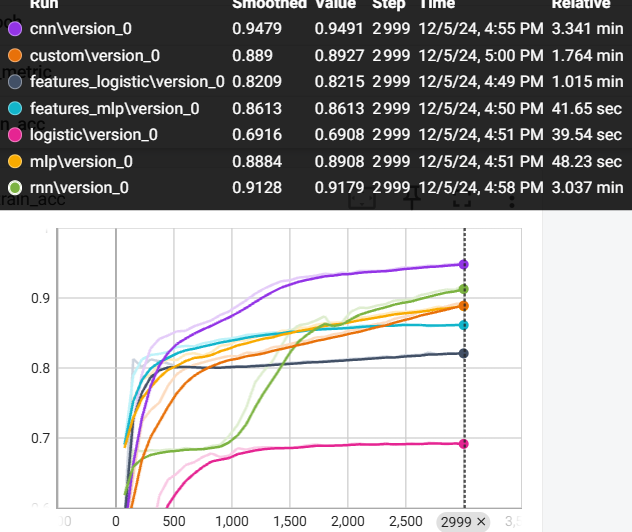

# Train Loss
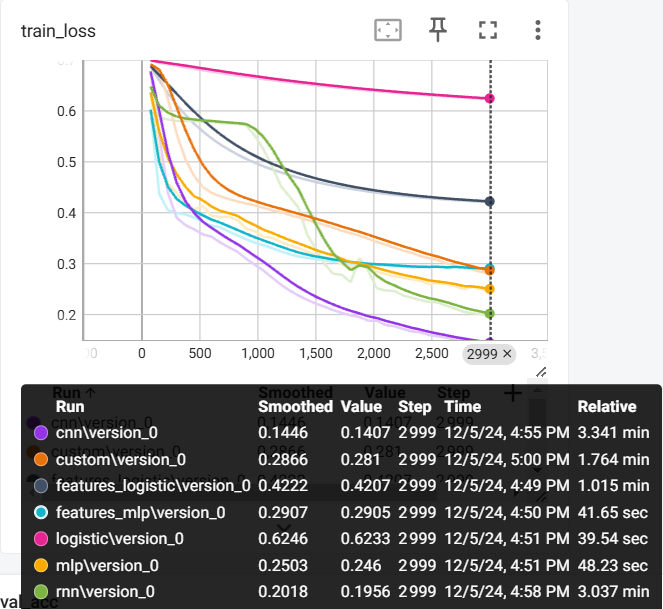

# Validation Accuracy
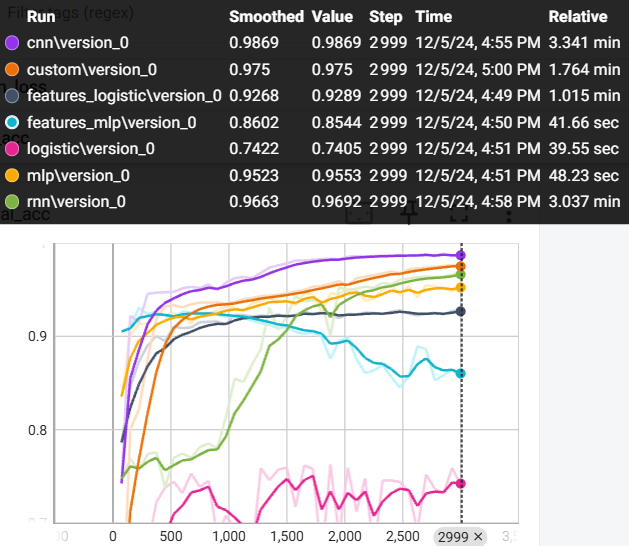

# Validation Loss
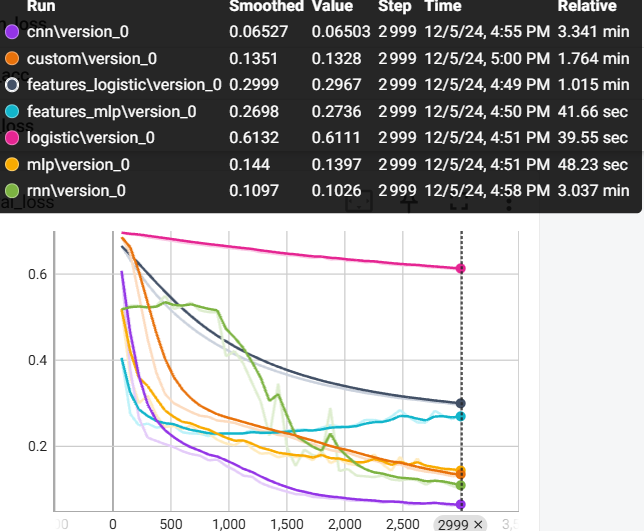

**Answer:**

1. A convolution is a special case of a linear transformation. While a linear layer is defined by the $m \times n$ coefficients of the associated matrix, where $m$ and $n$ are the output and input dimensions respectively, a convolutional layer is defined by its kernel, which is much smaller than the input and output dimensions. This allows the CNN model to have less parameters in total despite having more layers, as each layer has much less parameters.
2. All models show a validation accuracy higher than their training accuracy, suggesting that they are not overfitting. The exception is the features_MLP because the Validation Loss is increasing at later epochs, indicating overfitting. Overall the best model is the CNN model and the worst is the Logistic one. The CNN and RNN are able to capture the temporal dependencies between subsequent data samples thanks to their architectures.
3. The logistic model cannot learn non-linear features such as the variance, which we have seen to be significantly different between atrial fibrillation and normal fibrillation. Hence, the model performs much better when these features are used as inputs.
4. Training more epochs will only benefit models that have not yet reached a plateau in their loss curves. The CNN reaches a plateau in its validation loss and the `features_mlp` clearly has an increasing validation loss at later epochs. Therefore, those models will not benefit from additional epochs. We guess that the MLP and RNN will continue improving with further training.

Now that all models are trained we can evaluate them on the subsets for training, validation, and testing. For each model, we compute the following metrics:

* Accuracy (ACC)
* True positive rate (TPR)
* True negative rate (TNR)
* Positive predictive value (PPV)
* Negative predictive value (NPV)
* F1 score (F1)

You can find more information about these metrics on [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix).

In [ ]:
metrics = []
for name, model in models.items():
    x = features if name.startswith('features') else intervals
    y = targets
    df = evaluate_model(model, x, y, i_train, i_val, i_test, batch_size=batch_size)
    df.insert(0, 'model', name)
    metrics.append(df)
metrics = pd.concat(metrics, axis=0, ignore_index=True)
metrics = metrics.set_index(['model', 'subset'])
index = metrics.index.get_level_values(0).unique()
columns = pd.MultiIndex.from_product([metrics.columns, metrics.index.get_level_values(1).unique()])
metrics = metrics.unstack().reindex(index=index, columns=columns)
IPython.display.display(metrics)

We can also plot the different metrics.

In [ ]:
def plot_metrics(data):
    for metric in data.columns.get_level_values(0).unique():
        if metric == 'count':
            continue
        df = data[metric]
        plt.figure(constrained_layout=True)
        plt.gca().set_axisbelow(True)
        df.plot(kind='bar', ylabel=metric, ax=plt.gca())
        plt.grid(axis='y')
        plt.ylim(0.6, 1.0)
        plt.legend(loc='lower right')
        plt.gca().xaxis.set_tick_params(rotation=45)

    
plot_metrics(metrics)

**Question 4**

Based on the performance metrics shown above, answer the following questions:

1. Which are the best models?
2. What can you say about the models using features as inputs?
3. Bonus question: do you think it is *honest* to compare several models based on metrics computed on the test set in order to select the best one ?

**Answer:**

1. From the F1-score, the CNN is the best model. The RNN, MLP and `features_logistic` are all slightly worse, but still significantly better than `features_mlp` and `logistic`.
2. `features_logistic` is tremendously better than the `logistic` model. However, the MLP performs worse when using features as inputs. This may be because the MLP can learn better features from the raw data, thanks to its architecture.
3. It would be better to do so using metrics computed on the validation set. Indeed, the test set should only be used as an indicator of the model's performance when presented with data it has never seen before.

**Question 5**

Train and evaluate a model with a custom configuration. Can you obtain better performance than the previous models?

In [ ]:
# Customize the model configuration below.
custom_config_name = 'custom'
custom_config = {
    'model': {
        'name': 'cnn',
        'config': {
            'input_size': intervals.shape[1], 
            'output_size': targets.shape[1],
            'n_layers': 3,
            'n_initial_channels': 16,
            'kernel_size': 5,
        },
    },
    'optimizer': {
        'name': 'adam',
        'config': {'lr': 0.0001},
    },
}

custom_model = train_model(custom_config_name, custom_config, intervals, targets, i_train, i_val, n_epochs, batch_size)
custom_metrics = evaluate_model(custom_model, intervals, targets, i_train, i_val, i_test, batch_size)
IPython.display.display(custom_metrics)

Yes. We obtain better performance (accuracy) by adding an additional layer. 